<a href="https://colab.research.google.com/github/surajsarkar/deepLearning/blob/main/notebooks/07_tensorflow_milestone_project_food101_big.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Food Vision 101 Mile Stone**

## Check GPU


In [ ]:
!nvidia-smi -L 

GPU 0: Tesla T4 (UUID: GPU-cbba016b-75e7-8452-d475-c4dc012042f3)


## Get the helper function

In [ ]:
# Get the helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-23 05:02:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-23 05:02:11 (69.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use Tensorflow Datasets to Download Data

In [ ]:
# Get the tensorflow datasets
import tensorflow_datasets as tfds

In [ ]:
# List all the available datasets
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [ ]:
(train_data, test_data), ds_info = tfds.load(name="food101", 
                                             split=["train", "validation"],
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             shuffle_files=True,
                                             with_info=True # This will download the meta data which will be stored in ds_info
                                             )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteHRLOVV/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteHRLOVV/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Take one sample of the train data
train_one_sample = train_data.take(1)

In [ ]:
# What does one sample of train data look like 
print(train_one_sample)

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [ ]:
for image, label in train_one_sample:
  print(f"""
  Image shape = {image.shape}
  Image datatype = {image.dtype}
  Target class from food 101 (tensor form) = {label}
  Class name (str form) = {class_names[label]}
  {label.numpy()}
  """)


  Image shape = (512, 512, 3)
  Image datatype = <dtype: 'uint8'>
  Target class from food 101 (tensor form) = 16
  Class name (str form) = cheesecake
  16
  


## Plot a Image from Tensorflow Dataset

(512, 512, 3)


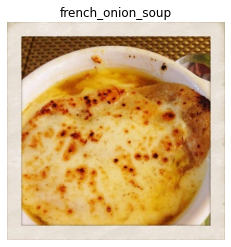

In [ ]:
import matplotlib.pyplot as plt 
import tensorflow as tf
for img, label in train_one_sample:
  print(img.shape)
  plt.imshow(tf.cast(img, dtype="float32")/255.)
  plt.title(class_names[label.numpy()])
  plt.axis(False)

## Create preprocessing function for our data 

In [ ]:
# Make a function for pre-processing image
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from uint8 -> float32 
  and reshape images to [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  return tf.cast(image, tf.float32), label



In [ ]:
# preprocess the single image and see the output
preprocessed_img = preprocess_img(img, label)[0]
print(f"Image before preprocessing \n {img[:3, 3]}.... \n Image Shape: {img.shape} \n Image dtype: {img.dtype}")
print(f"Image after preprocessing \n {preprocessed_img[:3, 3]}.... \n Image Shape: {preprocessed_img.shape} \n Image dtype: {preprocessed_img.dtype}")

Image before preprocessing 
 [[198 178 153]
 [208 188 163]
 [207 190 164]].... 
 Image Shape: (512, 512, 3) 
 Image dtype: <dtype: 'uint8'>
Image after preprocessing 
 [[208.4643  192.4643  172.9643 ]
 [210.64285 196.96428 175.5357 ]
 [207.      193.5     171.     ]].... 
 Image Shape: (224, 224, 3) 
 Image dtype: <dtype: 'float32'>


## Batch and prepare dataset

In [ ]:
# Map preprocessing function to training (and parallels)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train data and turn it into batches and prefetch it(load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
#Shuffle the test data and turn it into batches and prefetch it
test_data = test_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callback

Some of the callback that we will create:
* ModelCheckpoint callback (to save the progress of the `feature extraction model`)
* TensorBoard callback (to analyze the profermence of the model)


In [ ]:
# Create a TensorBoard callback (import it from helper_functions)
from helper_functions import create_tensorboard_callback

# Create a ModelCheckpoint callback
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      )

## Setup mixed precision training

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


## Build a feature extraction model

In [ ]:
# 1. Create a base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# 2. Create a input layer
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input layer")

# 3. Pass the input layer to base_model
x = base_model(inputs, training=False)

# 4. Create a pooling layer
x = tf.keras.layers.GlobalAveragePooling2D(name="global_pooling_layer")(x)

# 5. Create a output layer
x = tf.keras.layers.Dense(len(class_names))(x)

outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

# 6. Create a model 
model = tf.keras.Model(inputs, outputs)

# 7. Compile a model 
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_pooling_layer (Globa  (None, 1280)             0         
 lAveragePooling2D)                                              
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Checking layer dtype policies

In [ ]:
for layer in model.layers:
  print(layer.dtype, layer.dtype_policy)

float32 <Policy "float32">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "float32">


In [ ]:
for layer in model.layers:
  print(layer.name)

input layer
efficientnetb0
global_pooling_layer
dense
softmax_float32


In [ ]:
# Check the dtype_policy for our backbone model
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

## Fit the feature extraction model 

In [ ]:
# Fit the model
history_0 = model.fit(train_data,
          epochs=3,
          steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=len(test_data),
          callbacks=[create_tensorboard_callback("tensorboard", "model_initial"), model_checkpoint])

Saving TensorBoard log files to: tensorboard/model_initial/20220623-052821
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8220 - accuracy: 0.5574WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 244s 95ms/step - loss: 1.8220 - accuracy: 0.5574 - val_loss: 1.2242 - val_accuracy: 0.6794
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2937 - accuracy: 0.6670WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 219s 92ms/step - loss: 1.2937 - accuracy: 0.6670 - val_loss: 1.1293 - val_accuracy: 0.6951
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1422 - accuracy: 0.7021WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 220s 92ms/step - loss: 1.1422 - accuracy: 0.7021 - val_loss: 1.0898 - val_accuracy: 0.7050


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-cbba016b-75e7-8452-d475-c4dc012042f3)
